<a href="https://colab.research.google.com/github/rajatyadav1998/facebook-friend-recommendation/blob/main/facebook_data_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [3]:
df = pd.read_csv("train.csv")
print(df.head())


   source_node  destination_node
0          741           1190227
1          741           1742231
2          741           1149308
3          799            735020
4          799             99403


In [6]:
df.columns


Index(['source_node', 'destination_node'], dtype='object')

In [7]:
df['link'] = 1


In [8]:
import random
import pandas as pd

# All nodes
all_nodes = list(set(df['source_node']).union(set(df['destination_node'])))
existing_edges = set(zip(df['source_node'], df['destination_node']))

# Generate 1:1 ratio of negative samples
neg_samples = set()
while len(neg_samples) < len(df):
    u = random.choice(all_nodes)
    v = random.choice(all_nodes)
    if u != v and (u, v) not in existing_edges and (v, u) not in existing_edges:
        neg_samples.add((u, v))

# Create negative edge DataFrame
df_neg = pd.DataFrame(list(neg_samples), columns=['source_node', 'destination_node'])
df_neg['link'] = 0

# Combine with the original
df_all = pd.concat([df, df_neg], ignore_index=True)


In [9]:
import networkx as nx

# Build graph from positive edges only
G = nx.from_pandas_edgelist(df[df['link'] == 1], 'source_node', 'destination_node')


In [10]:
def common_neighbors(u, v):
    return len(list(nx.common_neighbors(G, u, v)))

def preferential_attachment(u, v):
    return list(nx.preferential_attachment(G, [(u, v)]))[0][2]


In [11]:
df_all['common_neighbors'] = df_all.apply(lambda row: common_neighbors(row['source_node'], row['destination_node']), axis=1)
df_all['pref_attachment'] = df_all.apply(lambda row: preferential_attachment(row['source_node'], row['destination_node']), axis=1)


In [12]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_all[['common_neighbors', 'pref_attachment']]
y = df_all['link']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[19664  1804]
 [15946  5214]]

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.92      0.69     21468
           1       0.74      0.25      0.37     21160

    accuracy                           0.58     42628
   macro avg       0.65      0.58      0.53     42628
weighted avg       0.65      0.58      0.53     42628

ROC-AUC Score: 0.6192915058346833


In [15]:
# Prepare a set of node pairs
edges_to_score = list(zip(df_all['source_node'], df_all['destination_node']))

# Jaccard
jaccard_scores = list(nx.jaccard_coefficient(G, edges_to_score))
jaccard_dict = {(u, v): p for u, v, p in jaccard_scores}
df_all['jaccard'] = df_all.apply(lambda row: jaccard_dict.get((row['source_node'], row['destination_node']), 0), axis=1)


In [16]:
# Adamic-Adar
aa_scores = list(nx.adamic_adar_index(G, edges_to_score))
aa_dict = {(u, v): p for u, v, p in aa_scores}
df_all['adamic_adar'] = df_all.apply(lambda row: aa_dict.get((row['source_node'], row['destination_node']), 0), axis=1)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features and target
features = ['common_neighbors', 'pref_attachment', 'jaccard', 'adamic_adar']
target = 'link'

X = df_all[features]
y = df_all[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Train RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.58      0.73      0.65     21468
           1       0.63      0.47      0.54     21160

    accuracy                           0.60     42628
   macro avg       0.61      0.60      0.60     42628
weighted avg       0.61      0.60      0.60     42628

[[15673  5795]
 [11124 10036]]


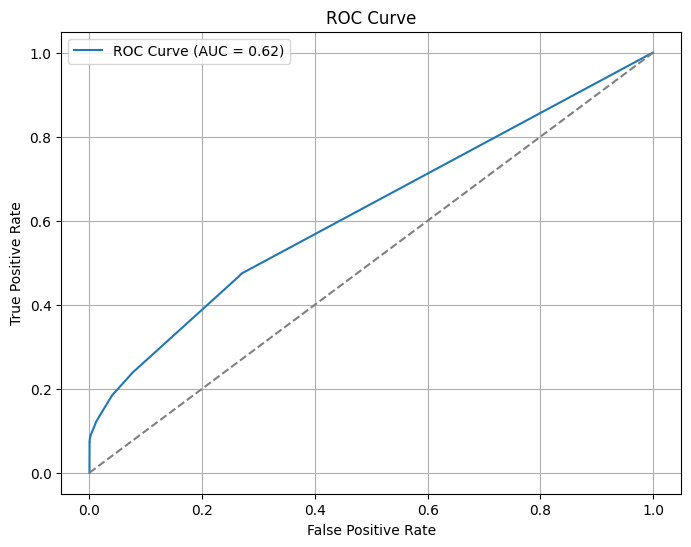

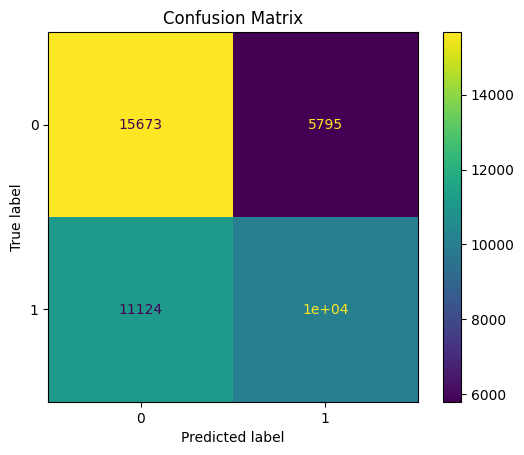

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ROC-AUC
y_probs = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [20]:
import joblib

# Save model
joblib.dump(rf, "friend_recommendation_model.pkl")

# Save the graph object (if needed)
joblib.dump(G, "friend_graph.pkl")


['friend_graph.pkl']

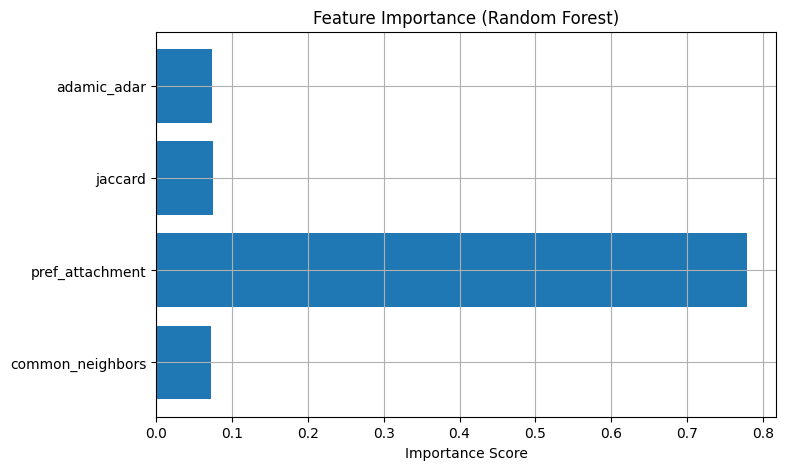

In [21]:
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.grid()
plt.show()


In [22]:
!apt-get install git -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [23]:
!git config --global user.name "Rajat yadav"
!git config --global user.email "rajatyadav1998@example.com"


In [24]:
!git config --global user.name "rajatyadav"
!git config --global user.email "rajatyadav1998@gmail.com"


In [25]:
!git clone https://github.com/rajatyadav1998/facebook-friend-recommendation.git


Cloning into 'facebook-friend-recommendation'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [26]:
!mv "facebook_data_mining.ipynb" facebook-friend-recommendation/


mv: cannot stat 'facebook_data_mining.ipynb': No such file or directory


In [27]:
!ls


facebook-friend-recommendation	friend_recommendation_model.pkl  train.csv
friend_graph.pkl		sample_data


In [28]:
!ls


facebook-friend-recommendation	friend_recommendation_model.pkl  train.csv
friend_graph.pkl		sample_data
